Train a model to recognize handwritten digits using numpy

- Load the MNIST dataset from the web and store as NumPy arrays
- Train a simple model to solve MNIST using PyTorch
- Do the same with NumPy by implementing various ML algorithms

In [54]:
%pylab inline
import numpy as np
from tqdm import trange

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [55]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [56]:
# X_train: training images
# Y_train: training labels
# X_test: Test images
# Y_test: test labels

# reshapes data into format where each image is 28x28 pixels
# flatten 2D images in to 1D arrays, with 784 columns
# 60000 as number of images in dataset 748 = 28*28
X_train.reshape(-1, 28*28).shape

(60000, 784)

(<matplotlib.image.AxesImage at 0x28d5d34d0>, 0)

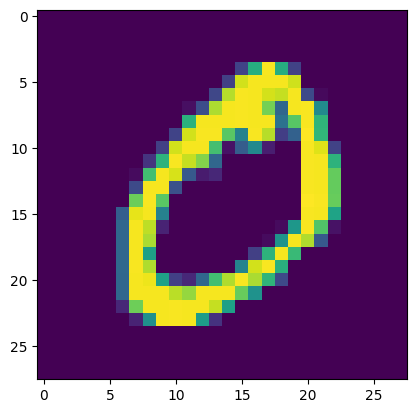

In [57]:
imshow(X_train[1]), Y_train[1]

In [58]:
# model in pytorch
import torch
import torch.nn as nn

# implement in pytorch
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128)
    self.act = nn.ReLU()
    self.l2 = nn.Linear(128,10)
  def forward(self,x):
    x = self.l1(x)
    x = self.act(x)
    x = self.l2(x)
    return x
model = BobNet()

In [59]:
X_train.shape

(60000, 28, 28)

In [60]:
# don't be a noob
s = X_train[0:10].reshape(-1,28*28)
float_tensor = torch.tensor(s).float()
mo = model(float_tensor)

In [61]:
np.random.randint(0,100, size=32)

array([74, 42, 88, 53, 11, 72, 33, 17, 73, 12, 97, 56, 74, 62, 96, 12, 13,
       27, 64, 57, 70, 97, 72, 61, 27, 72,  0, 19, 85, 71, 37, 21])

loss 0.03 accuracy 0.97: 100%|██████████| 1000/1000 [00:01<00:00, 971.46it/s]


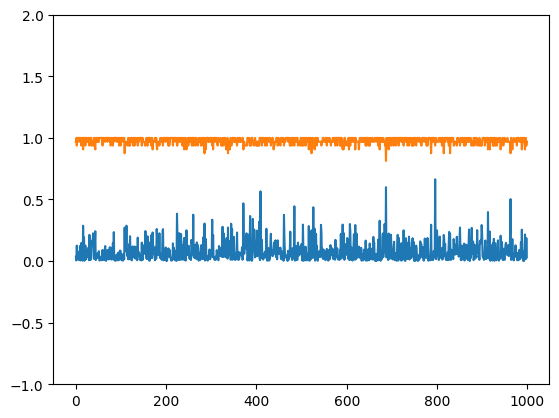

In [103]:
# quick training loop model
BS = 32
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
# what's SGD? what's learning rate?

losses, accuracies = [], []

for i in (t:= trange(1000)):
  samp = np.random.randint(0,X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  optim.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat==Y).float().mean()
  # crossentropyloss class?
  loss = loss_func(out, Y)
  # back propagation
  loss.backward()
  # torch optimizer? adam?
  # updates the weights of the neural network to minimize the loss function
  # adam is automatically adjusts the learning rate during training and often performs well in practice
  # zero_grad. george forgot to do that in 1 of example lol
  optim.step()

  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)

  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-1,2)
plot(losses)
plot(accuracies)

In [104]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9599

# From Scratch!
Goal is to have the same result as pytorch

In [105]:
# init the network
# what's linear layer? what's relu?
# why float32?
# why twist the shape?
l1 = np.zeros((128,784), dtype=np.float32)
l2 = np.zeros((10, 128), dtype=np.float32)

l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 10966222864, 10962213488)

In [106]:
model.l1.weight

Parameter containing:
tensor([[ 0.0050, -0.0252, -0.0273,  ...,  0.0023, -0.0217,  0.0099],
        [ 0.0293,  0.0143,  0.0086,  ...,  0.0209,  0.0119, -0.0128],
        [-0.0094,  0.0007, -0.0352,  ...,  0.0114, -0.0187, -0.0073],
        ...,
        [ 0.0339, -0.0179, -0.0045,  ...,  0.0015,  0.0276,  0.0172],
        [-0.0153, -0.0253, -0.0222,  ...,  0.0356, -0.0155,  0.0074],
        [ 0.0069, -0.0034, -0.0350,  ..., -0.0196,  0.0210, -0.0340]],
       requires_grad=True)

In [107]:
# copy weights from pytorch

l1[:] = model.l1.weight.detach().numpy()
l2[:] = model.l2.weight.detach().numpy()

In [108]:
# numpy forward pass
# a NN with 2 layers
def forward(x):
    x = x.dot(l1.T)
    x = np.maximum(x, 0)
    x = x.dot(l2.T)
    return x

Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
# predicted labels for test set
Y_test_preds = np.argmax(Y_test_preds_out, axis=1) # select the index of the max value in each row

Y_test_preds_out = forward(X_test.reshape((-1,28*28)))    

(Y_test == Y_test_preds).mean() # accuaracy

0.9599

In [109]:
# TODO: calculate cross entropy loss

In [110]:
print(np.log(np.exp(Y_test_preds_out[0]).sum()))

# what does x[class] mean?
print(Y_test[0])

print(Y_test_preds_out[0,7])

-Y_test_preds_out[0, 7] + np.log(np.exp(Y_test_preds_out[0]).sum())

21.908985
7
21.908978


7.6293945e-06

In [111]:
samp = 1
-Y_test_preds_out[samp, Y_test[samp]] + np.log(np.exp(Y_test_preds_out[samp]).sum())

1.9073486e-05

In [112]:
# arrayiyfied
-np.array([Y_test_preds_out[i, Y_test[i]] for i in range(Y_test_preds_out.shape[0])]) + np.log(np.exp(Y_test_preds_out).sum(axis=1))

array([7.6293945e-06, 1.9073486e-05, 3.0708313e-04, ..., 4.7302246e-04,
       4.1961670e-05, 0.0000000e+00], dtype=float32)

In [113]:
# howw?
print(np.array([Y_test_preds_out[i, Y_test[i]] for i in range(Y_test_preds_out.shape[0])]))
Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test]

[21.908978 25.463863 13.849381 ... 28.184416 32.23974  24.758312]


array([21.908978, 25.463863, 13.849381, ..., 28.184416, 32.23974 ,
       24.758312], dtype=float32)

In [114]:
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

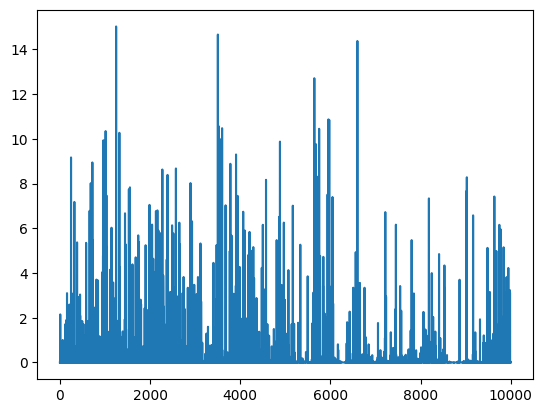

In [115]:
plot(ret)

1247
10.568312
9


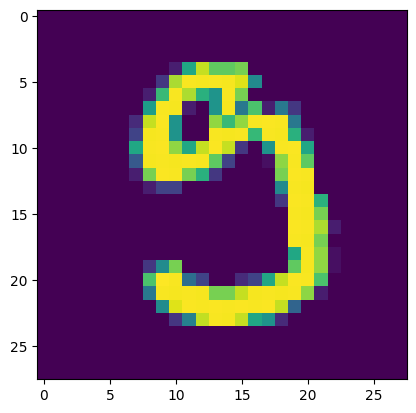

In [119]:
# highest uncertainty
print(np.argmax(ret))
print(Y_test[np.argmax(ret)])

imshow(X_test[np.argmax(ret)])


In [ ]:
#TODO: impelement backpropagation
#TODO: implement optimization
#TODO: putting it all together
#TODO: eval
